# Python: Protecting Whales from Ships 
## EDS 223 Assignment 03 
### Authors: Grace Kumaishi & Julia Parish | Group 22
### Submission Date: 2021-11-16

In [2]:
import pandas as pd
import geopandas as gpd
import gpxpy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Polygon
import numpy as np
import contextily as cx

## Table of Contents

[1) Dominica outline](#dominica)
    
[2) Whale sighting data](#sighting)<br>
&ensp;&ensp;&ensp;[2.1 Create grid](#grid)<br>
&ensp;&ensp;&ensp;[2.2 Extract whale habitat](#habitat)<br>
&ensp;&ensp;&ensp;[2.3 Create Speed Reduction Zone](#reduction)

[3) Vessel data](#vessel)<br>
&ensp;&ensp;&ensp;[3.1 Calculate distance and speed](#speeddistance)<br>
&ensp;&ensp;&ensp;[3.2 Impact on shipping travel time](#time)

[4) References](#references)

<a id='dominica'></a> 

## Dominica outline

Find Dominica’s outline and load the outline using the GeoPandas read_file() function.

In [3]:
dominica = gpd.read_file("data/dominica/dma_admn_adm0_py_s1_dominode_v2.shp")

Inspect the outline’s CRS and—if needed—project the outline into a locally appropriate metric CRS.

In [4]:
dominica.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
dominica = dominica.to_crs('epsg:2002')

Plot the outline for exploration. Use subplots to configure your canvas.

In [6]:
titlefont = {'family': 'sans-serif',
        'color':  'k',
        'weight': 'bold',
        'size': 14,
        }

Text(0.5, 1.0, 'Dominica')

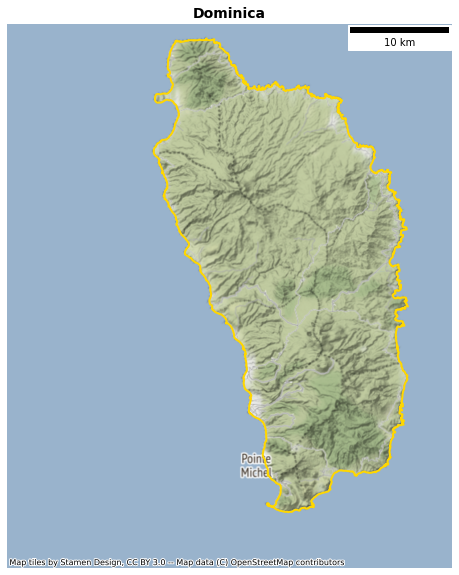

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set(xlim=(4.4e5, 4.85e5), ylim=(1.675e6, 1.73e6))

dominica.plot(ax=ax, edgecolor="gold", linewidth = 2, facecolor="None")
cx.add_basemap(ax, crs=dominica.crs.to_string())

scalebar = ScaleBar(1, "m", 
                    length_fraction=0.25, 
                    location="upper right",
                    pad=0.2,
                    border_pad=0.1,)
ax.add_artist(scalebar)

ax.axis('off')
ax.set_title("Dominica", fontdict=titlefont)

<a id='sighting'></a> 

## Whale sighting data
The data/sightings2005_2018.csv contains times and point locations of approximately 5,000 whale sightings in Dominica between 2008 and 2015. You can load it using GeoPandas’ read_file() function. Note that after you load the data, there is no geometry set; merely the columns Lat and Long. Bootstrap the geometries and project the dataset into an appropriate CRS.
Hints:
geopandas.points_from_xy()
geopandas.GeoDataFrame.set_geometry

In [8]:
sightings = gpd.read_file("data/sightings2005_2018.csv")  

In [9]:
sightings_geo = gpd.points_from_xy(sightings.Long, sightings.Lat)
sightings = gpd.GeoDataFrame(sightings, geometry=sightings_geo, crs="EPSG:4326").to_crs(2002)

Convert the point observations into a habitat region. Start by creating a sampling grid and determining the number of sightings in each grid cell. Then threshold the number of sightings per cell to create a subset of cells which we’ll determine to be the habitat.

<a id='grid'></a> 

### Create Grid
Boundaries: These will be the bounding box of the whale sightings. We can retrieve the bounding coordinates of the sightings from the total_bounds attribute of our sightings dataframe.

Cell size: We’ll use 2,000 m (2 km) for both the vertical and horizontal size.

In [10]:
# Call sightings to ensure unpacking array parameters are correct
sightings.total_bounds

array([ 408480.65208369, 1532792.74594092,  498500.30495702,
       1796964.39970292])

Unpack array.

In [11]:
minx, miny, maxx, maxy = sightings.total_bounds 
minx, miny, maxx, maxy

(408480.65208368783, 1532792.7459409237, 498500.3049570159, 1796964.3997029224)

Create a function to make a cell.

In [12]:
def make_cell(x, y, cell_size):
    ring = [
        (x, y),
        (x + cell_size, y),
        (x + cell_size, y + cell_size),
        (x, y + cell_size)
    ]
    cell = Polygon(ring)
    return cell

Establish cell size and create an evenly spaced range of x,y.

In [13]:
cell_size = 2000

xs = np.arange(minx, maxx, cell_size)
ys = np.arange(miny, maxy, cell_size)

In [14]:
cells = []
for x in xs:
    for y in ys:
        cell = make_cell(x, y, cell_size)
        cells.append(cell)

Set geometry.

In [15]:
sightings_grid = gpd.GeoDataFrame({'geometry': cells}, crs=2002)

Plot sightings grid.

(400000.0, 505000.0, 1520000.0, 1810000.0)

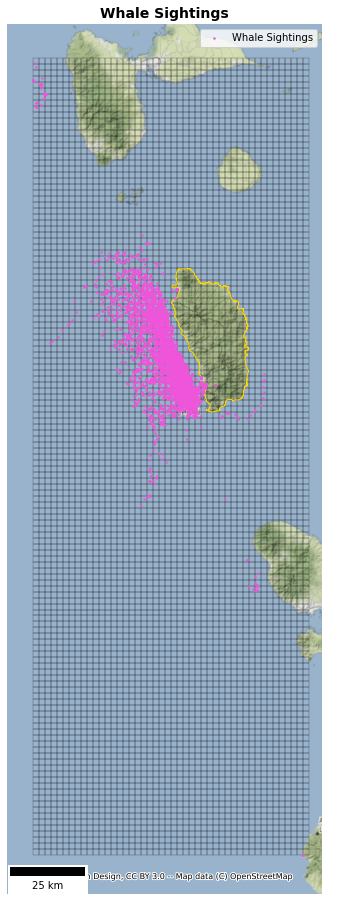

In [58]:
fig, ax = plt.subplots(figsize=(10, 16))
ax.set(xlim=(4.0e5, 5.05e5), ylim=(1.52e6, 1.81e6))

sightings_grid.plot(ax=ax, linewidth = 0.2, edgecolor="black", facecolor="None")                       
dominica.plot(ax=ax, edgecolor="gold", linewidth = 1, facecolor="None")
sightings.plot(ax=ax, color="#EF55DA", markersize=2, label="Whale Sightings")

cx.add_basemap(ax, crs=dominica.crs.to_string())
ax.set_title("Whale Sightings", fontdict=titlefont)

scalebar = ScaleBar(1, "m", 
                    length_fraction=0.25, 
                    location="lower left",
                    pad=0.2,
                    border_pad=0.1,)
ax.add_artist(scalebar)

ax.legend()
ax.axis('off')


<a id='habitat'></a> 

### Extract whale habitat

Spatially join the sightings grid with sighting data to be able to count the number of sightings in each cell.

In [17]:
habitat = sightings_grid.sjoin(sightings, how="inner")

Create whale habitat. 

(403880.65208368783,
 505080.65208368783,
 1519492.7459409237,
 1812092.7459409237)

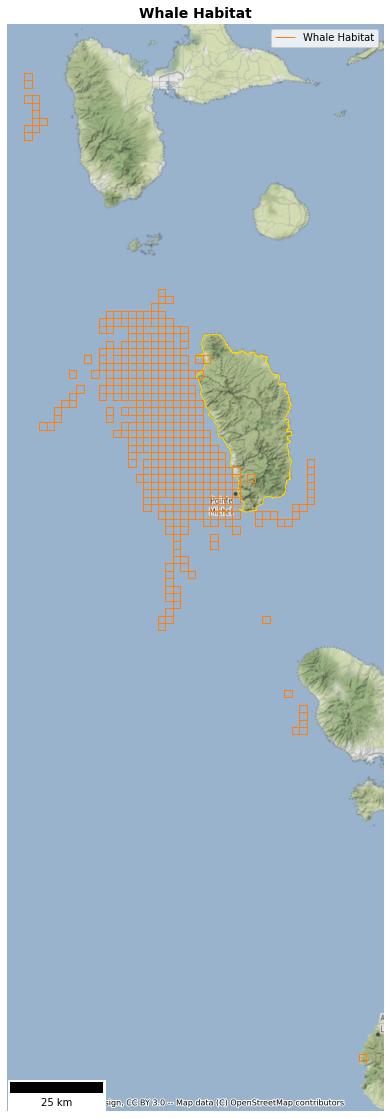

In [59]:
fig, ax = plt.subplots(figsize=(8, 20))
                    
habitat.boundary.plot(ax=ax, linewidth = 1, color = "C1", label="Whale Habitat")
dominica.plot(ax=ax, edgecolor="gold", linewidth = 1, facecolor="None")

cx.add_basemap(ax, crs=dominica.crs.to_string())
ax.set_title("Whale Habitat", fontdict=titlefont)

scalebar = ScaleBar(1, "m", 
                    length_fraction=0.25, 
                    location="lower left",
                    pad=0.2,
                    border_pad=0.1,)
ax.add_artist(scalebar)

ax.legend()
ax.axis('off')

#### Create count of whale sightings in each cell:

Perform a map-reduce operation:

* Group the rows of the joined dataset; then
* reduce (summarize) each group

In [19]:
sightings_grid['count'] = habitat.groupby(habitat.index).count()['index_right']

Confirm count max:

In [20]:
sightings_grid['count'].max()

930.0

Confirm count min:

In [21]:
sightings_grid['count'].min()

1.0

Subset the sightings grid dataframe to cells with more than 20 sightings.

In [22]:
# Within sightings grid want count greater than 20 -setting True|False
sightings_subset = sightings_grid['count']>20

# Create object based on true values of subset
whale_zone = sightings_grid[sightings_subset]

Plot potential impact zone.

(442677.143635003, 482354.3295060693, 1678235.2282757242, 1730955.5776176918)

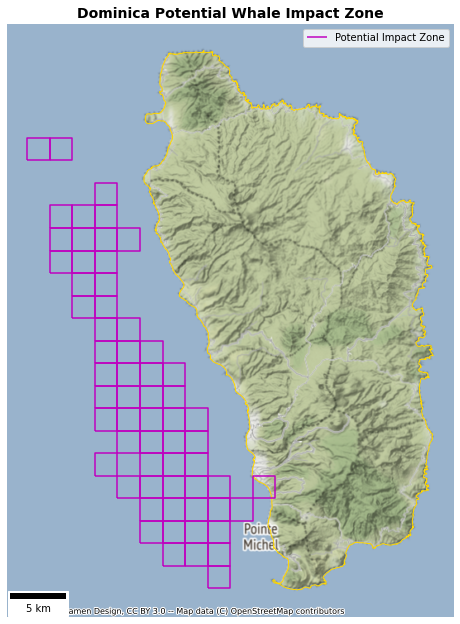

In [60]:
fig, ax = plt.subplots(figsize=(8, 12))

whale_zone.boundary.plot(ax=ax, color ="m", label="Potential Impact Zone")
dominica.plot(ax=ax, edgecolor="gold", linewidth = 1, facecolor="None")

cx.add_basemap(ax, crs=dominica.crs.to_string())
ax.set_title("Dominica Potential Whale Impact Zone", fontdict=titlefont)

scalebar = ScaleBar(1, "m", 
                    length_fraction=0.25, 
                    location="lower left",
                    pad=0.2,
                    border_pad=0.1,)
ax.add_artist(scalebar)

ax.legend()
ax.axis('off')

<a id='reduction'></a> 

## Create the speed reduction zone:

Extract the unary union of this subset and use the convex hull of this union as our speed reduction zone.

In [24]:
whale_zone_union = whale_zone.unary_union

In [25]:
speed_zone = whale_zone_union.convex_hull

speed_zone=gpd.GeoDataFrame(index=[0], geometry=[speed_zone], crs='epsg:2002')

#### Plot the speed reduction zone:

(442677.143635003, 482354.3295060693, 1678235.2282757242, 1730955.5776176918)

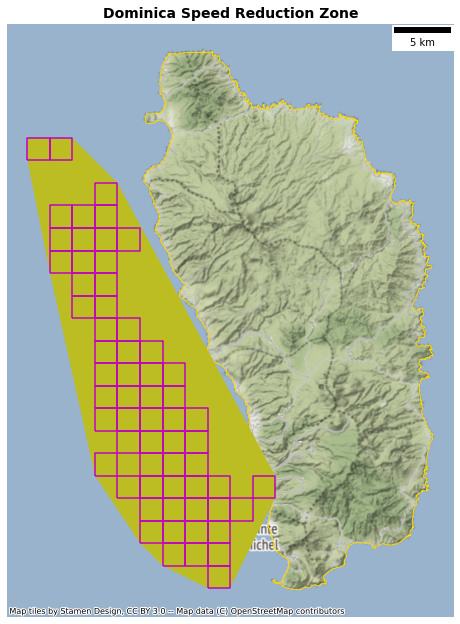

In [67]:
fig, ax = plt.subplots(figsize=(8, 12))

dominica.plot(ax=ax, edgecolor="gold", linewidth = 1, facecolor="None")
whale_zone.boundary.plot(ax=ax, color ="m", label ='Whale Habitat')
speed_zone.plot(ax=ax, color ="C8", label ='Speed Reduction Zone')

cx.add_basemap(ax, crs=dominica.crs.to_string())

scalebar = ScaleBar(1, "m", 
                    length_fraction=0.25, 
                    location="upper right",
                    pad=0.2,
                    border_pad=0.1,)
ax.add_artist(scalebar)

ax.set_title("Dominica Speed Reduction Zone", fontdict=titlefont)
ax.axis('off')

<a id='vessel'></a> 

## Vessel Data

### Load data

The Dominica Sperm Whale Project operated station 1249 on Dominica from 2021 to 2015. We are using data for 2015 only, in data/station1249.csv. the AIS dataset does not contain geometries, just LON and LAT columns. Bootstrap the geometries as you did for the whale sightings and project the dataset into an appropriate CRS

In [27]:
vessel = gpd.read_file("data/station1249.csv") 

Inspect the datatypes of the geodataframe.

In [31]:
vessel_geo = gpd.points_from_xy(vessel.LON, vessel.LAT)
vessel = gpd.GeoDataFrame(vessel, geometry=vessel_geo).set_crs("EPSG:4326").to_crs("EPSG:2002")

Spatially subset vessel data to the speed reduction zone.

In [32]:
vessel = gpd.clip(vessel, speed_zone)

Parse date/time strings

In [33]:
vessel['TIMESTAMP'] = pd.to_datetime(vessel['TIMESTAMP'])

(440000.0, 485000.0, 1675000.0, 1730000.0)

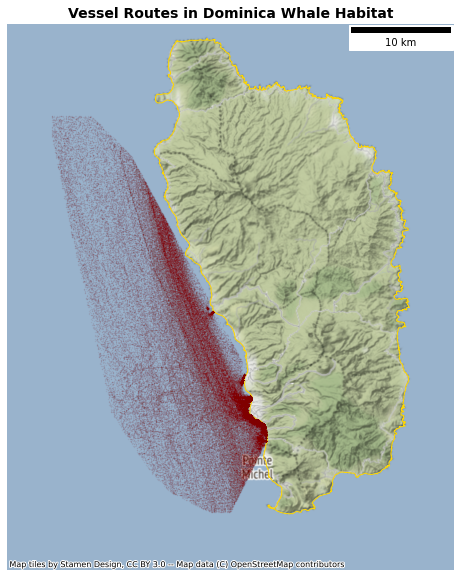

In [68]:
fig, ax = plt.subplots(figsize = (8, 12))
ax.set(xlim=(4.4e5, 4.85e5), ylim=(1.675e6, 1.73e6))

dominica.plot(ax = ax, edgecolor="gold", linewidth = 1, facecolor="None")
vessel.plot(ax = ax, markersize = .1, color = "maroon", alpha = .1)

scalebar = ScaleBar(1, "m", 
                    length_fraction=0.25, 
                    location="upper right",
                    pad=0.2,
                    border_pad=0.1,)
ax.add_artist(scalebar)

cx.add_basemap(ax, crs = 2002)

ax.set_title('Vessel Routes in Dominica Whale Habitat', fontdict=titlefont)
ax.axis('off')

<a id='speeddistance'></a> 

### Calculate vessel distance and speed
Sort dataframe (df) by MMSI and time using sort_values(). Create a copy of df (df2), shift each observation down one row using shift(). Join the original df with df2 using join(). Provide useful column name suffixes.

In [34]:
vessel.sort_values(by=['MMSI', 'TIMESTAMP'], inplace=True)

Shift rows down by 1

In [35]:
vessel_shift = vessel.shift(periods=1)

Join the original dataframe with the shifted copy

In [36]:
vessel_join = vessel_shift.join(vessel, rsuffix='_after')
vessel_join = vessel_join.drop(columns=['field_1', 'LON', 'LAT', 'LON_after', 'LAT_after', 'field_1_after'])

Drop all rows in joined dataframe in which the MMSI of the left is not the same as the one on the right.

In [37]:
vessel_join = vessel_join.drop(vessel_join.index[vessel_join['MMSI'] != vessel_join['MMSI_after']]) 

### Final calculations:
* The distance for each observation to the next
* The time difference between each observation to the next
* The average speed between each observation to the next
* The time that the distance would have taken at 10 knots.
* The difference between the time that it actually took and how much it would have taken at 10 knots.
*Hint: 1 knot is 1 sea mile per hour.*

Distance between observations:

In [38]:
vessel_join['distance'] = vessel_join['geometry_after'].distance(vessel_join['geometry'])

Time difference between observations:

In [39]:
vessel_join['time_diff'] = vessel_join['TIMESTAMP_after'] - vessel_join['TIMESTAMP']

In [40]:
vessel_join['time_diff_sec'] = vessel_join['time_diff'] / np.timedelta64(1, 's')

Average speed between each observation in meters per second

In [41]:
vessel_join['average_speed'] = vessel_join['distance'] / vessel_join['time_diff_sec']

Convert average speed to knots:

In [42]:
mps_per_1knot = .514

In [43]:
vessel_join['knots'] = vessel_join['average_speed'] / mps_per_1knot

Filter observations that are below 10 knots:

In [44]:
vessel_join = vessel_join.drop(vessel_join.index[vessel_join['knots'] < 10]) 

Calculate the time (seconds) it takes to travel a given distance at 10 knots:

In [45]:
vessel_join['time_10knots_sec'] = vessel_join['distance'] / (10 * mps_per_1knot)

Calculate travel time difference when ships slow to 10 knots:

In [46]:
vessel_join['time_lost'] = vessel_join['time_10knots_sec'] - vessel_join['time_diff_sec']

<a id='time'></a> 

## Impact on shipping travel time
Sum up all the time differences that are larger than 0. This represents our approximation to the impact on shipping (in terms of increased travel time) of a 10-knot reduced-speed zone in our identified whale habitat.

In [47]:
time_lost_seconds = vessel_join['time_lost'].sum()

In [48]:
seconds_per_day = 86400

In [49]:
time_lost_days = time_lost_seconds * (1/seconds_per_day)

In [50]:
time_lost_days

27.94232477326458

If all ships were required to travel at 10 knots or below during this time period, the total impact on shipping would be about 28 days. 

<a id='references'></a> 

## References

- Gerst, S., Ingulsrud, L., Johnson, S., Steffen, C. 2020. Whales and Vessels: Economic Valuation of Whale Watching and Marine Spatial Planning Surrounding Dominica. UCSB Bren School of Environmental Data Science Master of Environmental Science and Management: Master's Group Project.

- OpenStreetMap contributors. (2015) Planet dump [Data file from $2021-11-16$]. Retrieved from https://planet.openstreetmap.org."